# Images as Data Lab

Welcome to the images as data lab! By the end of this lecture, you will have

1. Combined images to make new images
2. Gained intuition for image template matching
3. Used convolution for feature detection
4. Used max-pooling to downsample images

Let's get started!

## Load Images

In [1]:
from IPython.display import display
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import array_to_img, img_to_array

[X_mnist, y_mnist], _ = mnist.load_data()
X_mnist = X_mnist.astype(np.float) / 255.

X_mnist.shape

Using TensorFlow backend.


(60000, 28, 28)

## Transform Images to Use With TensorFlow

In [2]:
X_tf = np.expand_dims(X_mnist, axis=-1)

X_tf.shape

(60000, 28, 28, 1)

## Get Images to Play Around With

In [3]:
imgs = [array_to_img(x, data_format='channels_first').resize(size=[128, 128]) for x in np.expand_dims(X_mnist, axis=1)]
X = np.array([img_to_array(img, data_format='channels_first') for img in imgs])

X.shape

(60000, 1, 128, 128)

#### Consider the Following Two Images...

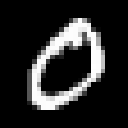

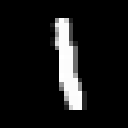

In [4]:
img0, img6 = imgs[1], imgs[6]

display(img0)
display(img6)

### Questions

Before doing anything, what will the resulting image will look like when we...

1. Add them?
2. Subtract them?
    1. Does the order of the subtraction matter? That is, will the resulting image look different depending on the order of the subtraction?
3. Multiply them?

### Answers

1. We will get an image which looks very much like a bitwise OR of the two images.
2. We will get an image which looks like a bitwise set subtraction of the two images (i.e. $I_1$ - $I_2$ will give us all of the pixels in $I_1$ but not $I_2$). Swapping the order of subtraction will still perform bitwise set subtraction, but the order of the subtraction is reversed.
3. We will get an image which looks very much like a bitwise AND of the two images.

### Tasks

- Compute these images to verify your answer

### Requirements

- Threshold each resulting image so that their minimum value is `0`

### Hints

- Recall how to convert back and forth between numpy arrays and PIL images. You will be doing this often during this lab.

![Converting Images](images/Converting%20Images.png)

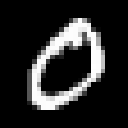

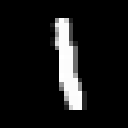

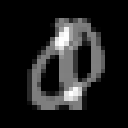

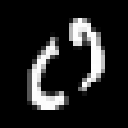

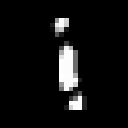

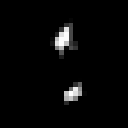

In [5]:
x0, x6 = img_to_array(img0, data_format='channels_first'), img_to_array(img6, data_format='channels_first')

x_add = x0 + x6
x_sub_left, x_sub_right = x0-x6, x6-x0
x_mul = x0 * x6

img_add = array_to_img(x_add, data_format='channels_first')
x_sub_right[x_sub_right < 0], x_sub_left[x_sub_left < 0] = 0, 0
img_sub_left, img_sub_right = array_to_img(x_sub_left, data_format='channels_first'), array_to_img(x_sub_right, data_format='channels_first')
img_mul = array_to_img(x_mul, data_format='channels_first')

display(img0)
display(img6)
display(img_add)
display(img_sub_left)
display(img_sub_right)
display(img_mul)

#### Consider the following three images...

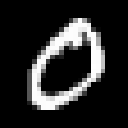

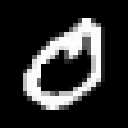

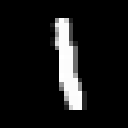

In [6]:
img0, img0_, img1 = imgs[1], imgs[21], imgs[6]

display(img0)
display(img0_)
display(img1)

### Question

- Will `np.sum(x0*x0_) > np.sum(x0*x1)` or `np.sum(x0*x0_) < np.sum(x0*x1)`? Justify your answer with intuition.

### Answer

- `np.sum(x0*x0_) > np.sum(x0*x1)` because `x0` and `x0_` have more overlapping pixels.

### Tasks

- Compute these quantities to verify your answer

In [7]:
x0, x0_, x1 = img_to_array(img0, data_format='channels_first'), img_to_array(img0_, data_format='channels_first'), img_to_array(img1, data_format='channels_first')

print(np.sum(x0*x0_), np.sum(x0*x1))

1.3416e+08 2.80862e+07


Consider the following keras architecture for classifying MNIST digits

![MNIST Keras](images/MNIST%20Keras.png)
and that we have optimized $\mathbf{W}$ to produce high scores for the correct digit class.


### Question

- If we take $w_i$ and *reshape it back into a $28 \times 28$ image* and display it, what might it look like? Why might this be the case?

### Answer

- Each of the columns will form approximately a template for its corresponding digit. For instance $w_0$ would be a template for zero. The product of an image that is a zero would have a higher value in the column of zero compared to the other ones.

### Tasks

- Define this architecture and train this model for 5 epochs in keras
- Reshape each $w_i$ back to a $28 \times 28$ image and display it

### Hints

- Use a softmax layer + categorical cross entropy loss
- Transform `y` from a `1darray` to a categorical `2darray` with `keras.utils.np_utils.to_categorical()`
    - Use the `28x28` `X_minst` variable as opposed to the `128x128` `X` variable in scope
- Use `keras.layers.Layer.get_weights()` to get the weights of a layer

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Flatten(input_shape=[28, 28, 1]))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_tf, to_categorical(y_mnist), epochs=5)

Epoch 1/5
60000/60000 [==============================] - 7s - loss: 0.4661 - acc: 0.8788       

In [9]:
W = model.layers[-1].get_weights()[0]

for i in range(10):
    w = W[:, i].reshape(X_tf[0].shape)
    img = array_to_img(w)
    display(img)

### Question

- List two advantages of using a linear classifier for images. List two disadvantages.

### Answer

| Advantages | Disadvantages |
| ---------- | ------------- |
| Interpretable | Often require feature engineering |
| Quick to optimize | Prone to underfitting |

### Question

- Compare and contrast a logistic regression MNIST classifier and a KNN classifier. When might a KNN classifier outperform linear regression?

### Answer

- There is a rough equivalence between a $N$-nearest neighbor classifier (where $N$ is the number of data points in the training set) and a logistic regression classifier. Indeed, averaging all members of a class and using this as a single data point is also similar to $N$-nearest neighbor and logistic regression. Linear regression can also incorporate *negative evidence* (e.g. the absense of a digit in a certain region) and class prevalence for improved prediction.
- KNN will outperform linear regression when there is high intra-class variation sub-members of a class form clusters which are close in the data space. For example, if there were two kinds of ways to write the digit zero and a logistic regression classifier could not separate these two types of zeros from all other digits, then a KNN classifier would likely perform better.

## Averaging Images

### Question

- What do you think the resulting image of averaging all images of `0` would look like? What about the average image for other numbers?

### Answer

- The average `0` image will look like a blurred zero. The average $D$ image will look like a blurred $D$.

### Task

- Compute the average image for every number and display it to verify your answer

### Hints

- Start by just handling `0` and then wrap this logic in a `for` loop to handle the remaining numbers

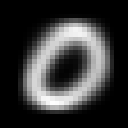

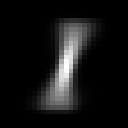

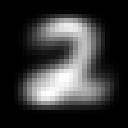

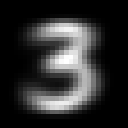

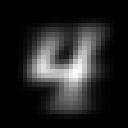

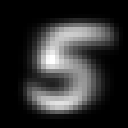

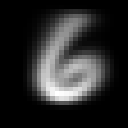

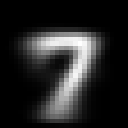

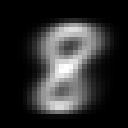

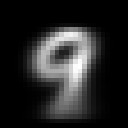

In [10]:
for i in range(10):
    i_mask = np.argwhere(y_mnist == i).flatten()
    X_i = X[i_mask]
    x = X_i.mean(axis=0)
    img = array_to_img(x, data_format='channels_first')
    display(img)

## Question

- How do these images compare with the columns of $W$ from the previous section? Do they look similar? Why might this be the case?

## Answer

- The images look similar because they are doing similar things as decribed above.

# Convolution

Consider the filter $
F =
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix}
$
and the image $x =$

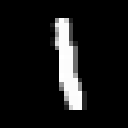

In [11]:
img1

- What will the resuling activation map $x \star F$ look like? What types of patches does $F$ produce the strongest activations for?

You will be able to pick out the vertical lines of the image.

### Tasks

- Convolve $w$ with $x$ and display the result

### Hints

- Use `scipy.signal.correlate2d()` with `mode='valid'`
- Since `scipy.signal.correlate2d()` expects a `2darray`, you will have to remove the color dimension from `x` with indexing and then tack it back on to the activation map returned by `scipy.signal.correlate2d()` with `np.expand_dims(axis=0)`

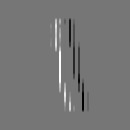

In [12]:
from scipy import signal

w = np.array([[-1, 0, 1],
              [-1, 0, 1],
              [-1, 0, 1]], dtype=np.float)

x_convolved = signal.correlate2d(x1[0], w)
array_to_img(np.expand_dims(x_convolved, axis=0), data_format='channels_first')

### Questions

- What about the filters
$
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1
\end{bmatrix},
\
\begin{bmatrix}
1 & 0 & -1 \\
1 & 0 & -1 \\
1 & 0 & -1
\end{bmatrix},
\
\begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix},
\
\begin{bmatrix}
1 & 1 & 1 \\
0 & 0 & 0 \\
-1 & -1 & -1
\end{bmatrix},
\
\begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & -1.5 \\
1 & -1.5 & 0
\end{bmatrix},
\
\begin{bmatrix}
1 & -1.5 & 0 \\
0 & 1 & -1.5 \\
0 & 0 & 1
\end{bmatrix}?
$

### Tasks

- Convolve these filters with $x$ and display the resulting activation maps to verify your answer

### Hints

- Write a function that convolves a filter with an image and displays the resulting activation map

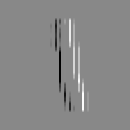

In [13]:
from scipy import signal

w = np.array([[1, 0, -1],
              [1, 0, -1],
              [1, 0, -1]], dtype=np.float)

x_convolved = signal.correlate2d(x1[0], w)
array_to_img(np.expand_dims(x_convolved, axis=0), data_format='channels_first')

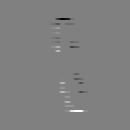

In [14]:
from scipy import signal

w = np.array([[1, 1, 1],
              [0, 0, 0],
              [-1, -1, -1]], dtype=np.float)

x_convolved = signal.correlate2d(x1[0], w)
array_to_img(np.expand_dims(x_convolved, axis=0), data_format='channels_first')

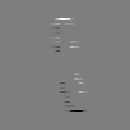

In [15]:
from scipy import signal

w = np.array([[-1, -1, -1],
              [0, 0, 0],
              [1, 1, 1]], dtype=np.float)

x_convolved = signal.correlate2d(x1[0], w)
array_to_img(np.expand_dims(x_convolved, axis=0), data_format='channels_first')

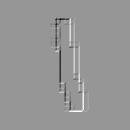

In [16]:
from scipy import signal

w = np.array([[0, 0, 1],
              [0, 1, -1.5],
              [1, -1.5, 0]], dtype=np.float)

x_convolved = signal.correlate2d(x1[0], w)
array_to_img(np.expand_dims(x_convolved, axis=0), data_format='channels_first')

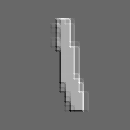

In [17]:
from scipy import signal

w = np.array([[1, -1.5, 0],
              [0, 1, -1.5],
              [1, 0, 1]], dtype=np.float)

a = signal.correlate2d(x1[0], w)
array_to_img(np.expand_dims(a, axis=0), data_format='channels_first')

## Pooling

We can think of a single convolutional image as a feature detector. For example, in the previous section we considered convolutional filters which produced strong activations for vertical edges. Instead of retaining the entire activation map (i.e. all the features that a single filter produces), we can downsample these activations by performing *max-pooling*.

### Questions

- List two reasons why max-pooling is useful and list two downsides.

| Advantages | Disadvantages |
| ---------- | ------------- |
| Increased sptial invariance | Loss of spatial information |
| Storage and space savings | Yet another hyperparameter to choose (e.g. pooling size) |

### Task

- Perform max-pooling on one of the activation maps from the previous section. Try different values `block_size` (e.g. in the range `1-20`)

### Hint

- Use `skimage.measure.block_reduce(..., func=np.max)` for **max**-pooling

pool_size=(1, 1)


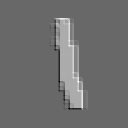

pool_size=(6, 6)


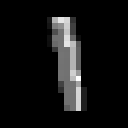

pool_size=(11, 11)


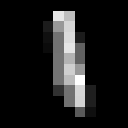

pool_size=(16, 16)


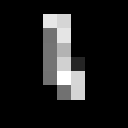

In [18]:
from skimage.measure import block_reduce

for i in range(1, 20, 5):
    pooled = block_reduce(a, (i, i), np.max)
    img = array_to_img(np.expand_dims(pooled, axis=0), data_format='channels_first')
    print(f'pool_size={(i, i)}')
    display(img.resize(size=[128, 128]))